# Dog breeds identification

Multi-class classification problem, we are asked to identify dog breeds from images of dogs.
The dataset comprises 120 breeds of dogs.

The dataset is deposited [here](https://www.kaggle.com/competitions/dog-breed-identification).


# Config

#### Python libraries

In [1]:
## SYSTEM LIBRARIES
import glob     #for checking dir content
import os       #for dir creation
import requests #for data download
import zipfile  #for unpacking zipped files

## DATA SCIENCE AND PREPROCESSING LIBRARIES
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt

## TENSORFLOW AND KERAS
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop

#### Support functions

In [2]:
## function to plot loos and accuracy over epochs
def plot_loss_history(h, title):
  for metric in h.history.keys():
    #ignoring metrics on validation set, which are implied when
    #plotting on training set
    if metric.startswith('val_'):
      continue
    
    #if we get here we found a metric on the training set,
    #let's plot it
    plt.plot(h.history[metric], label = "Train set")
    plt.plot(h.history["val_" + metric], label = "Validation set")
    plt.xlabel('Epochs')
    plt.title(title + ' - ' + metric)
    plt.legend()
    plt.show()

#### Parameters

In [4]:
#where the data are stored
#data_url = 'http://www.jackdellequerce.com/data/reduced_chest_xray.zip'
#data_url = 'https://cloud.cnr.it/owncloud/index.php/s/TU2f6k6gMOiPHci'
data_url = 'http://www.jackdellequerce.com/data/dogs/reduced.zip'
#where to place the data
download_target_imgs = '/content/data/'
base_dir = download_target_imgs + 'reduced/'

#Keras constants
BATCH_SIZE = 20
IMAGE_SIZE = [180, 180]
IMAGE_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1])
IMAGE_SHAPE_X = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
EPOCHS = 40

### Getting the data

The data are first downloaded as a zipped archive, which is then uncompressed and stored in `download_target_imgs` (the zipped archive has an internal structure with root `reduced/`)

In [63]:
#!rm -r /content/data/reduced/train

In [5]:
#room for data
os.makedirs(download_target_imgs, exist_ok=True)

#downloading
r = requests.get(data_url)
open(download_target_imgs + 'local_archive.zip', 'wb').write(r.content)

12170172

In [6]:
#unpacking
z = zipfile.ZipFile(download_target_imgs + 'local_archive.zip')
z.extractall(path = download_target_imgs)

In [7]:
 #at this point data is there, we are ready to get the list of files
train_filenames = glob.glob(base_dir + 'train/*')
test_filenames   = glob.glob(base_dir + 'test/*')

#whatever the original case, at this point we have the files
print('Available images for train: ' + str(len(train_filenames)))
print('Available images for test: ' + str(len(test_filenames)))

Available images for train: 317
Available images for test: 29


In [8]:
label_df = pd.read_csv(base_dir + 'labels_reduced.csv')
print('Training set: {}'.format(label_df.shape))

Training set: (317, 2)


In [9]:
label_df

,id,breed
0,07bbf36ce2c7407751219804b3d187ec,yorkshire_terrier
1,083820e6dda52da4c0f200ac36f582dc,yorkshire_terrier
2,0cb1bf12ae0fd5f681ae579c2a28ccd8,yorkshire_terrier
3,0f976e55b3634296183b2b1c051d5bda,yorkshire_terrier
4,0fa302727af44e7ad8033825cea98d7c,yorkshire_terrier
...,...,...
312,dc99d12a7cabf5d737be5a74bf56c3a9,saint_bernard
313,e562d56214836fc2621f01d53f25c44f,saint_bernard
314,e5861b5d5b08d0e03ca3e3785e44cc88,saint_bernard
315,e7faa5748d8320f604aeb3fd5bbe4ab0,saint_bernard


In [10]:
# Encode the breed into digits
label_df['label'] = preprocessing.LabelEncoder().fit_transform(label_df.breed)
 
# Create a breed-2-index dictionary
dict_df = label_df[['label','breed']].copy()
dict_df.drop_duplicates(inplace=True)
dict_df.set_index('label',drop=True,inplace=True)
 
index_to_breed = dict_df.to_dict()['breed']

In [11]:
label_df

,id,breed,label
0,07bbf36ce2c7407751219804b3d187ec,yorkshire_terrier,3
1,083820e6dda52da4c0f200ac36f582dc,yorkshire_terrier,3
2,0cb1bf12ae0fd5f681ae579c2a28ccd8,yorkshire_terrier,3
3,0f976e55b3634296183b2b1c051d5bda,yorkshire_terrier,3
4,0fa302727af44e7ad8033825cea98d7c,yorkshire_terrier,3
...,...,...,...
312,dc99d12a7cabf5d737be5a74bf56c3a9,saint_bernard,0
313,e562d56214836fc2621f01d53f25c44f,saint_bernard,0
314,e5861b5d5b08d0e03ca3e3785e44cc88,saint_bernard,0
315,e7faa5748d8320f604aeb3fd5bbe4ab0,saint_bernard,0


In [12]:
index_to_breed

{3: 'yorkshire_terrier',
 2: 'weimaraner',
 1: 'siberian_husky',
 0: 'saint_bernard'}

In [13]:
target = label_df['label'].to_numpy().tolist()
target = tf.keras.utils.to_categorical(target)

In [14]:
target = pd.DataFrame(target)
target = target.join(label_df['id'])
target['id'] = target['id'] + '.jpg'

In [15]:
#newcols = [str(x) for x in target.columns[:-1]]
#newcols.append('id')
#target.columns = newcols
target

,0,1,2,3,id
0,0.0,0.0,0.0,1.0,07bbf36ce2c7407751219804b3d187ec.jpg
1,0.0,0.0,0.0,1.0,083820e6dda52da4c0f200ac36f582dc.jpg
2,0.0,0.0,0.0,1.0,0cb1bf12ae0fd5f681ae579c2a28ccd8.jpg
3,0.0,0.0,0.0,1.0,0f976e55b3634296183b2b1c051d5bda.jpg
4,0.0,0.0,0.0,1.0,0fa302727af44e7ad8033825cea98d7c.jpg
...,...,...,...,...,...
312,1.0,0.0,0.0,0.0,dc99d12a7cabf5d737be5a74bf56c3a9.jpg
313,1.0,0.0,0.0,0.0,e562d56214836fc2621f01d53f25c44f.jpg
314,1.0,0.0,0.0,0.0,e5861b5d5b08d0e03ca3e3785e44cc88.jpg
315,1.0,0.0,0.0,0.0,e7faa5748d8320f604aeb3fd5bbe4ab0.jpg


### ImageDataGenerator

In [16]:
colnames = [x for x in target.columns[:-1]]

In [17]:
colnames

[0, 1, 2, 3]

In [66]:
#declare two objects
train_datagen      = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [67]:
training_set = target.sample(n=274)

In [68]:
df_all = target.merge(training_set['id'].drop_duplicates(), on=['id'], 
                   how='left', indicator=True)
validation_set = df_all[df_all['_merge'] == 'left_only']

In [69]:
train_generator = train_datagen.flow_from_dataframe(
dataframe=training_set,
directory=base_dir + 'train/',
x_col="id",
y_col=colnames,
batch_size=BATCH_SIZE,
seed=42,
shuffle=False,
class_mode="raw",
target_size=IMAGE_SHAPE)

Found 274 validated image filenames.


In [70]:
valid_generator = validation_datagen.flow_from_dataframe(
dataframe=validation_set,
directory=base_dir + 'train/',
x_col="id",
y_col=colnames,
#y_col = 'classes',
batch_size=BATCH_SIZE,
seed=42,
shuffle=False,
class_mode="raw",
target_size=IMAGE_SHAPE)

Found 43 validated image filenames.


In [23]:
target.shape

(317, 5)

In [71]:
#let's declare an empty model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", input_shape=IMAGE_SHAPE_X))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))
#model.add(Dense(units=5, activation='softmax')) #five classes classification problem
######################

In [72]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 129600)           

In [73]:
# Model compile
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=2e-4),
              metrics=['accuracy'])

In [74]:
train_log = model.fit(x=train_generator,
                    validation_data=valid_generator,
                    verbose=2,
                    epochs=EPOCHS
)

Epoch 1/40
14/14 - 3s - loss: 1.7961 - accuracy: 0.3285 - val_loss: 1.3946 - val_accuracy: 0.2791 - 3s/epoch - 189ms/step
Epoch 2/40
14/14 - 1s - loss: 1.3807 - accuracy: 0.3066 - val_loss: 1.4068 - val_accuracy: 0.2558 - 1s/epoch - 102ms/step
Epoch 3/40
14/14 - 1s - loss: 1.3676 - accuracy: 0.3358 - val_loss: 1.4039 - val_accuracy: 0.2093 - 1s/epoch - 103ms/step
Epoch 4/40
14/14 - 2s - loss: 1.3431 - accuracy: 0.3431 - val_loss: 1.3875 - val_accuracy: 0.2791 - 2s/epoch - 155ms/step
Epoch 5/40
14/14 - 2s - loss: 1.2746 - accuracy: 0.4307 - val_loss: 1.3812 - val_accuracy: 0.2558 - 2s/epoch - 128ms/step
Epoch 6/40
14/14 - 1s - loss: 1.2613 - accuracy: 0.4416 - val_loss: 1.3835 - val_accuracy: 0.3256 - 1s/epoch - 101ms/step
Epoch 7/40
14/14 - 1s - loss: 1.2413 - accuracy: 0.4416 - val_loss: 1.3766 - val_accuracy: 0.2558 - 1s/epoch - 102ms/step
Epoch 8/40
14/14 - 1s - loss: 1.1795 - accuracy: 0.5073 - val_loss: 1.3705 - val_accuracy: 0.3023 - 1s/epoch - 105ms/step
Epoch 9/40
14/14 - 1s - 

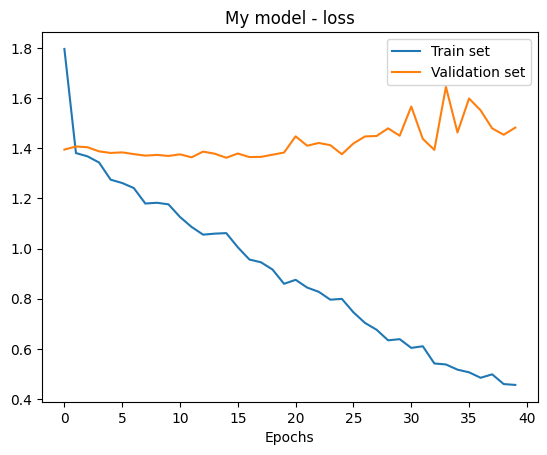

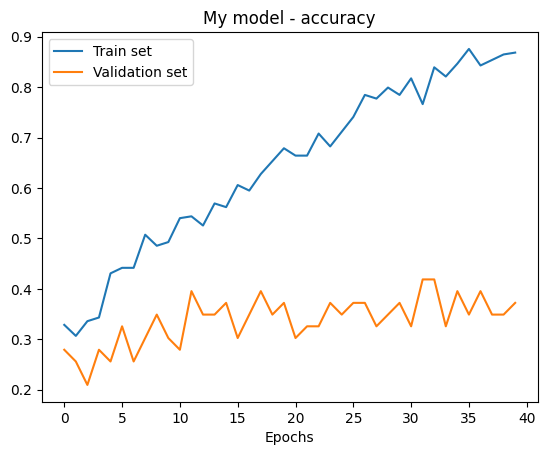

In [75]:
plot_loss_history(train_log, 'My model')

In [76]:
valid_generator.reset()
pred = model.predict(valid_generator,
verbose=0)

In [32]:
pred

array([[3.66432726e-01, 4.12005521e-02, 7.57195279e-02, 5.16647160e-01],
       [6.32783473e-02, 1.90621048e-01, 5.27971983e-01, 2.18128592e-01],
       [9.87016261e-02, 4.15045559e-01, 4.00117487e-01, 8.61353204e-02],
       [9.67862143e-05, 2.73758138e-04, 1.04702106e-02, 9.89159286e-01],
       [1.12874985e-01, 2.64576636e-03, 4.10525709e-01, 4.73953545e-01],
       [3.11634559e-02, 1.61577296e-02, 8.30199897e-01, 1.22478850e-01],
       [1.51161206e-04, 2.29865089e-02, 9.39174175e-01, 3.76881659e-02],
       [2.68519521e-01, 3.48388225e-01, 2.30614066e-01, 1.52478218e-01],
       [2.80327909e-03, 2.83546210e-03, 3.72391552e-01, 6.21969700e-01],
       [5.00550121e-02, 5.15678346e-01, 1.32383764e-01, 3.01882893e-01],
       [4.60854284e-02, 3.18829194e-02, 8.12418461e-01, 1.09613232e-01],
       [3.55215892e-02, 3.54925171e-02, 8.54655147e-01, 7.43307173e-02],
       [4.30084765e-02, 3.74624163e-01, 9.51726809e-02, 4.87194687e-01],
       [6.38822909e-04, 1.46732607e-03, 9.96894717e

In [77]:
y_pred = np.argmax(pred, axis=1)
y_pred

array([3, 1, 3, 2, 3, 3, 1, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 0, 0, 2, 3, 1,
       1, 1, 0, 0, 3, 0, 1, 3, 1, 1, 1, 1, 0, 2, 1, 2, 0, 0, 1, 0, 0])

In [78]:
obs = []
for vec in valid_generator.labels:
  obs.append(np.argmax(vec))

In [79]:
obs = np.array(obs)

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_mat = confusion_matrix(obs, y_pred)
print(conf_mat)

[[5 4 2 0]
 [3 5 0 2]
 [6 4 1 1]
 [0 3 2 5]]


In [81]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels= [x for x in reversed(index_to_breed.values())])

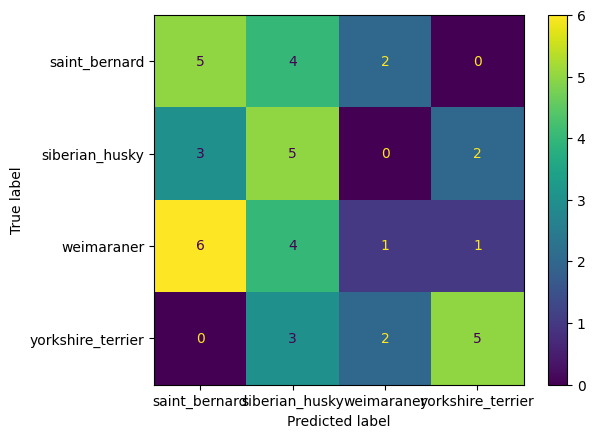

In [82]:
disp.plot()

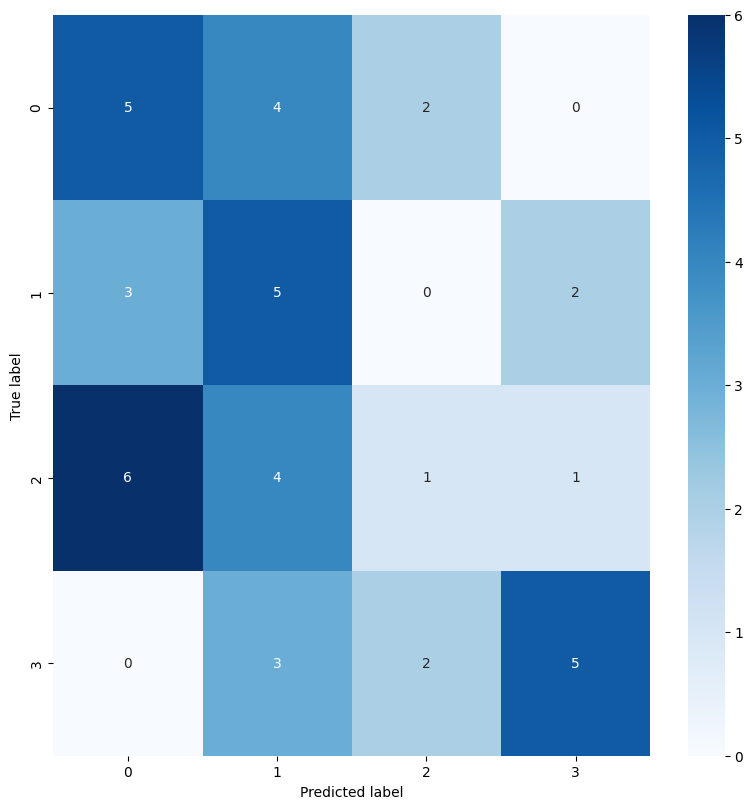

In [83]:
import seaborn as sn

figure = plt.figure(figsize=(8, 8))
sn.heatmap(conf_mat, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### TEST DATA

In [84]:
label_test = pd.read_csv(base_dir + 'labels_test.csv')
print('Test set: {}'.format(label_df.shape))

# Encode the breed into digits
label_test['label'] = preprocessing.LabelEncoder().fit_transform(label_test.breed)
 
# Create a breed-2-index dictionary
dict_df = label_test[['label','breed']].copy()
dict_df.drop_duplicates(inplace=True)
dict_df.set_index('label',drop=True,inplace=True)
 
index_to_breed = dict_df.to_dict()['breed']

Test set: (317, 3)


In [85]:
test = label_test['label'].to_numpy().tolist()
test = tf.keras.utils.to_categorical(test)

In [86]:
test = pd.DataFrame(test)
test = test.join(label_test['id'])
test['id'] = test['id'] + '.jpg'
test

,0,1,2,3,id
0,0.0,0.0,0.0,1.0,e2e10aeca2bcd6e9d9d91cd64efc13a8.jpg
1,0.0,0.0,0.0,1.0,e86503273b282ab18bd09c6b6ef63de7.jpg
2,0.0,0.0,0.0,1.0,e8827c1b0698e56e60f735b142d69d18.jpg
3,0.0,0.0,0.0,1.0,f23dffefcd4ae2dee8a5dbf67e41b699.jpg
4,0.0,0.0,0.0,1.0,f28c40401e84e41f5aa4c60fea02a575.jpg
5,0.0,0.0,0.0,1.0,f7627680c56c5d3acc4f7eae93124459.jpg
6,0.0,0.0,0.0,1.0,fb1cdd8ff249b6ee7c2af2e89ff644d4.jpg
7,0.0,0.0,1.0,0.0,ea77bbe28a68e90a21bbef677493ad65.jpg
8,0.0,0.0,1.0,0.0,ea9ae902f4ca9241c1187992c51db9bb.jpg
9,0.0,0.0,1.0,0.0,f58531d21504bc086aa5d0e2c945f988.jpg


In [87]:
colnames = [x for x in test.columns[:-1]]
colnames

[0, 1, 2, 3]

In [88]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [89]:
test_generator = test_datagen.flow_from_dataframe(
dataframe=test,
directory=base_dir + 'test/',
x_col="id",
y_col=colnames,
#y_col = 'classes',
batch_size=BATCH_SIZE,
seed=42,
shuffle=False,
class_mode="raw",
target_size=IMAGE_SHAPE)

Found 29 validated image filenames.


In [90]:
index_to_breed

{3: 'yorkshire_terrier',
 2: 'weimaraner',
 1: 'siberian_husky',
 0: 'saint_bernard'}

yorkshire_terrier


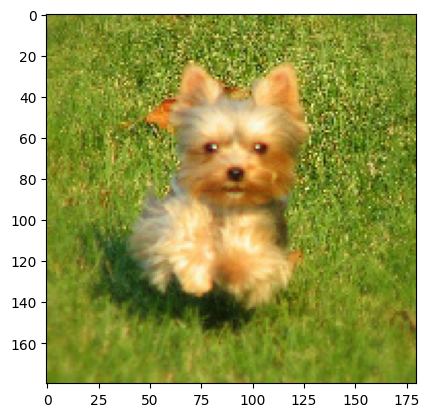

In [91]:
x, y = test_generator.next()
print(index_to_breed[np.argmax(y[0])])
plt.imshow(x[0])
plt.show()

In [92]:
test_generator.reset()
pred = model.predict_generator(test_generator,verbose=1)
y_pred = np.argmax(pred, axis=1)
y_pred

1/2 [==============>...............] - ETA: 0s

<ipython-input-92-7ad46552b5bd>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_generator,verbose=1)


2/2 [==============================] - 0s 34ms/step


array([0, 3, 1, 3, 2, 3, 0, 0, 2, 1, 0, 2, 1, 2, 1, 0, 1, 0, 3, 0, 1, 0,
       0, 1, 3, 0, 1, 0, 3])

In [93]:
obs = []
for vec in test_generator.labels:
  obs.append(np.argmax(vec))
obs = np.array(obs)

In [94]:
df = pd.DataFrame({'obs' : obs, 'preds' : y_pred})
df2 = df.replace({"obs": index_to_breed, "preds" : index_to_breed})
df2

,obs,preds
0,yorkshire_terrier,saint_bernard
1,yorkshire_terrier,yorkshire_terrier
2,yorkshire_terrier,siberian_husky
3,yorkshire_terrier,yorkshire_terrier
4,yorkshire_terrier,weimaraner
5,yorkshire_terrier,yorkshire_terrier
6,yorkshire_terrier,saint_bernard
7,weimaraner,saint_bernard
8,weimaraner,weimaraner
9,weimaraner,siberian_husky


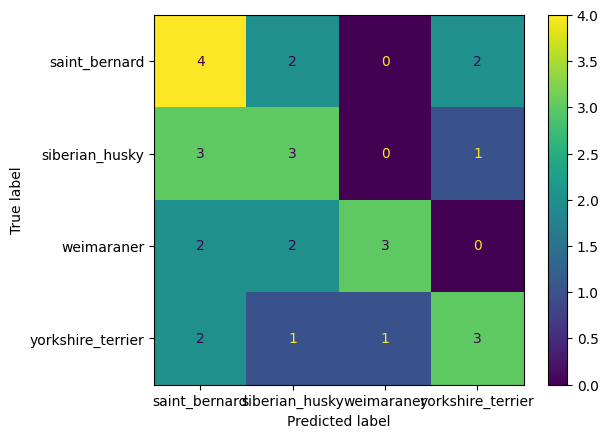

In [95]:
conf_mat = confusion_matrix(obs, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels= [x for x in reversed(index_to_breed.values())])
disp.plot()

### image_dataset_from_directory

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
!rm -r /content/data/reduced/test